In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score

In [3]:
df = pd.read_csv('/content/drive/MyDrive/Assigment-pro/events.csv')

In [4]:
df['event_time'] = pd.to_datetime(df['event_time'])

In [6]:
df['event_time'] = df['event_time'].dt.tz_localize(None)

In [7]:
print(f"Missing values: \n{df.isnull().sum()}")
print(f"Duplicates: {df.duplicated().sum()}")

Missing values: 
event_time            0
event_type            0
product_id            0
category_id           0
category_code    236219
brand            212364
price                 0
user_id               0
user_session        165
dtype: int64
Duplicates: 655


In [8]:
df = df.drop_duplicates()

In [9]:
print(df.head())

           event_time event_type  product_id          category_id  \
0 2020-09-24 11:57:06       view     1996170  2144415922528452715   
1 2020-09-24 11:57:26       view      139905  2144415926932472027   
2 2020-09-24 11:57:27       view      215454  2144415927158964449   
3 2020-09-24 11:57:33       view      635807  2144415923107266682   
4 2020-09-24 11:57:36       view     3658723  2144415921169498184   

                   category_code        brand   price              user_id  \
0          electronics.telephone          NaN   31.90  1515915625519388267   
1    computers.components.cooler       zalman   17.16  1515915625519380411   
2                            NaN          NaN    9.81  1515915625513238515   
3  computers.peripherals.printer       pantum  113.81  1515915625519014356   
4                            NaN  cameronsino   15.87  1515915625510743344   

  user_session  
0   LJuJVLEjPT  
1   tdicluNnRY  
2   4TMArHtXQy  
3   aGFYrNgC08  
4   aa4mmk0kwQ  


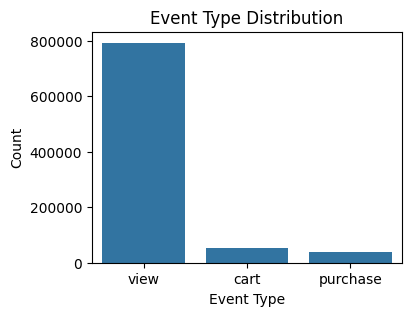

In [10]:
event_counts = df['event_type'].value_counts()
plt.figure(figsize=(4, 3))
sns.barplot(x=event_counts.index, y=event_counts.values)
plt.title("Event Type Distribution")
plt.xlabel("Event Type")
plt.ylabel("Count")
plt.show()

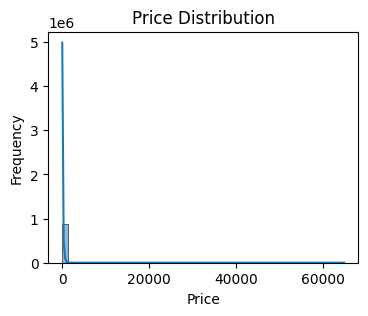

In [11]:
plt.figure(figsize=(4, 3))
sns.histplot(df['price'], bins=50, kde=True)
plt.title("Price Distribution")
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.show()

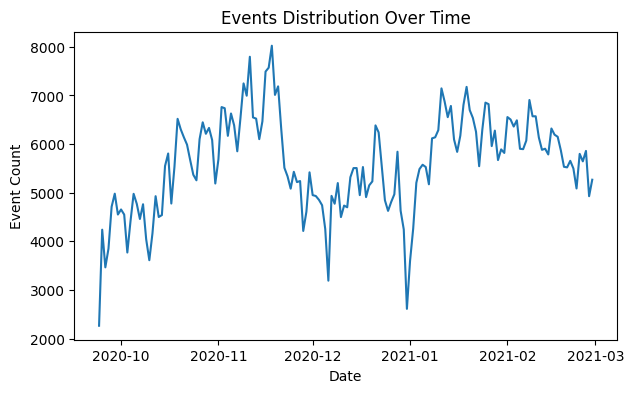

In [12]:
df['date'] = df['event_time'].dt.date
event_time_distribution = df.groupby('date').size()
plt.figure(figsize=(7, 4))
event_time_distribution.plot()
plt.title("Events Distribution Over Time")
plt.xlabel("Date")
plt.ylabel("Event Count")
plt.show()

In [13]:
user_summary = df.groupby('user_id').agg(
    total_spent=('price', 'sum'),
    event_count=('event_type', 'count'),
    unique_products=('product_id', 'nunique')
).reset_index()

In [14]:
top_users = user_summary.sort_values(by='total_spent', ascending=False).head(10)
print(top_users)

                    user_id  total_spent  event_count  unique_products
249967  1515915625568273951    209144.53          312                6
296210  1515915625593056776    191944.85          231               27
210031  1515915625554995474    179380.04          572                9
283996  1515915625591251010    178982.15          363               35
175991  1515915625542603891    144095.90           41                2
64167   1515915625527763086    133032.08          424               18
275913  1515915625573582886     87431.76           18                1
319320  1515915625596222123     79884.90          199               33
322843  1515915625596734979     73515.60          238               14
276988  1515915625573753643     69726.33            3                1


In [15]:
last_purchase_date = df[df['event_type'] == 'purchase'].groupby('user_id')['event_time'].max()
last_purchase_date = pd.to_datetime(last_purchase_date)

In [16]:
churn_threshold = datetime.now() - pd.Timedelta(days=30)
churned_users = last_purchase_date[last_purchase_date < churn_threshold].index

In [17]:
df['churn'] = df['user_id'].isin(churned_users).astype(int)

In [18]:
rfm = df.groupby('user_id').agg(
    recency=('event_time', lambda x: (datetime.now() - x.max()).days),
    frequency=('event_type', 'count'),
    monetary=('price', 'sum')
).reset_index()

In [19]:
session_features = df.groupby('user_id')['user_session'].nunique().reset_index()
session_features.rename(columns={'user_session': 'session_count'}, inplace=True)

In [20]:
user_behavior = df.groupby('user_id').agg(
    total_views=('event_type', lambda x: (x == 'view').sum()),
    total_carts=('event_type', lambda x: (x == 'cart').sum()),
    total_purchases=('event_type', lambda x: (x == 'purchase').sum())
).reset_index()

In [21]:
user_features = rfm.merge(session_features, on='user_id').merge(user_behavior, on='user_id')

In [22]:
user_features['view_to_cart_ratio'] = user_features['total_views'] / (user_features['total_carts'] + 1)
user_features['cart_to_purchase_ratio'] = user_features['total_carts'] / (user_features['total_purchases'] + 1)

In [23]:
user_features['churn'] = df.groupby('user_id')['churn'].first().values

In [24]:
X = user_features.drop(columns=['user_id', 'churn'])
y = user_features['churn']

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [26]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [27]:
y_pred = model.predict(X_test)

In [28]:
print(f"Classification Report:\n{classification_report(y_test, y_pred)}")
print(f"ROC AUC Score: {roc_auc_score(y_test, y_pred)}")

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    115885
           1       1.00      1.00      1.00      6300

    accuracy                           1.00    122185
   macro avg       1.00      1.00      1.00    122185
weighted avg       1.00      1.00      1.00    122185

ROC AUC Score: 1.0


In [29]:
feature_importances = model.feature_importances_
features = X.columns

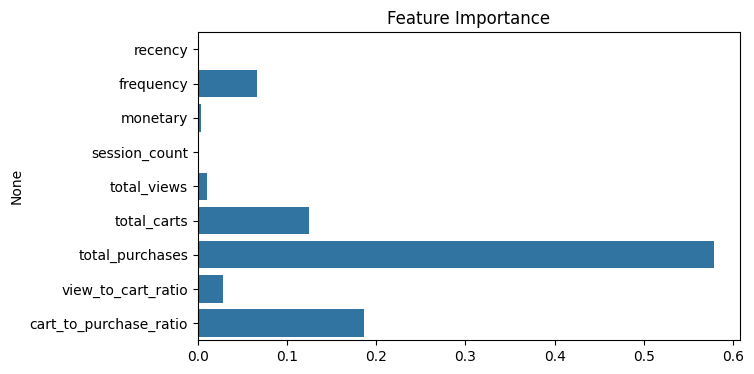

In [30]:
plt.figure(figsize=(7, 4))
sns.barplot(x=feature_importances, y=features)
plt.title("Feature Importance")
plt.show()

In [31]:
import joblib
joblib.dump(model, 'churn_predictor_model.pkl')
joblib.dump(user_features, 'user_features.pkl')

['user_features.pkl']